In [242]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from metronome import p_func, interval_calc
import numba
from tqdm import tqdm

In [243]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('hls', 10, desat = 0.8)
#colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

#sns.palplot(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.7
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [244]:
### Taken from Scientific Reports paper "Groups clapping in unison undergo..."
### https://www.nature.com/articles/s41598-017-18539-9
@numba.njit
def slope_fork(x_j):
    '''
    Piece wise function from Scientific Reports paper
    
    Parameters
    --------------
    x_j : float
        Phase of clapper

        
    Returns
    --------------
    slope value: float
        Value of the piece wise function depending on the phase of the clapper

    '''
    if x_j >= 0.5:                                                  # If phase is greater than 0.5
        return 1                                                    # Positive slope (clapper is dragged forward in phase)
    else:
        return -1                                                   # Negative slope (clapper is dragged bakckward in phase)

@numba.njit
def update_x(x_j, eps_clapper, N_tot):
    ''' 
    Update of clappers phase using 'slope fork' function. 
    Function takes two parameters, the phase of the clapper and eps_clapper. 
    It returns either 0, 1 or a phase in between depending on the phase and epsilon.  

    Parameters
    --------------
    x_j : float
        Phase of clapper

    eps_clapper : float
        Epsilon value for clapper coupling

    N_tot : int
        Total number of clappers

        
    Returns
    --------------
    x_up : float or int
        Updated phase of clapper
    
    '''

    x_up = x_j + (slope_fork(x_j) * eps_clapper) / N_tot           # Updated phase of clapper using function on p.5 in Scientific Reports paper
    if 0 < x_up < 1:
        return x_up
    elif x_up >= 1:                                                # If phase is greater than 1 return 1 to keep phase between 0 and 1 (almost)
        return 1
    else:
        return 0                                                   # If phase is less than 0 return 0 to keep phase between 0 and 1 (almost)
    
@numba.njit
def met_update_x(x_j, met_eps):
    ''' 
    Update of clappers phase when metronome claps. Again using 'slope fork' function. The coupling constant is metronome epsilon. 
    The function is slightly different from the update_x function as it is independent of the total number of clappers.
    Function takes two parameters, the phase of the clapper and the metronome epsilon (coupling constant between metronome and clappers).
    It returns either 0, 1 or a phase in between depending on the phase and the metronome epsilon.
    
    Parameters
    --------------
    
    x_j : float
        Phase of clapper

    met_eps : float
        Epsilon value for metronome coupling

    
    Returns
    --------------
    x_up : float or int
        Updated phase of clapper

    '''


    x_up = x_j + (slope_fork(x_j) * met_eps)                    # Updated phase of clapper using function on p.5 in Scientific Reports paper.
    if 0 < x_up < 1:
        return x_up
    elif x_up >= 1:
        return 1
    else:
        return 0


### Taken from paper "Keeping Synchrony while Tempo Changes: Accelerando and Ritardando"  
### https://www.jstor.org/stable/10.1525/mp.2005.22.3.461
@numba.njit
def interval_calc(bpm_i, bpm_f, p):
    ''' 
    Function to calculate the i'th interval between the metronome beats. 
    During the tempo transition phase the intervals, C_i, follow a sigmoidal function (see p_func).
    The function takes three parameters, the initial bpm, the final bpm and the p value from the p_func function.
    It returns the i'th interval between the metronome beats.

    Parameters
    --------------
    bpm_i : int
        Initial bpm value
    
    bpm_f : int
        Final bpm value

    p : float
        p value from p_func function:
        Can take values 0, 1 or a value between 0 and 1 depending on which interval (i) is being calculated.

    
    Returns
    --------------
    c_i : float
        Value of the i'th interval between the metronome beats n_i and n_{i+1}

    '''
    c_start = 60 / bpm_i                                         # Initial interval
    c_end = 60 / bpm_f                                           # Final interval
    c_i = p * c_start + (1 - p) * c_end                          # Calculating the i'th interval between the metronome beats
    return c_i

@numba.njit
def p_func(n_beat, threshold_l = 24, threshold_h = 40):
    ''' 
    Function to calculate p value for 'interval_calc' function using the current number of beats (n_i).
    The function takes the number of beats, n_beat, and two threshold values, threshold_l and threshold_h.
    It returns either 0, 1 or a value between 0 and 1 depending on how many beats have gone by.

    Parameters
    --------------
    n_beat : int
        Number of beats that have gone by

    threshold_l : int
        How many beats before the tempo transition starts

    threshold_h : int
        How many beats before the tempo transition ends

    
    
    Returns
    --------------
    p : float
        Value of p depending on the number of beats that have gone by.
        Either 0, 1 or a value between 0 and 1.

    '''


    if n_beat <= threshold_l:
        p = 1
    elif n_beat > threshold_l and n_beat <= threshold_h:
        p = 1/2 * (1 + np.cos(np.pi * (n_beat - threshold_l) / (threshold_h - threshold_l + 1)))  
    else:
        p = 0 
    return p

def avg_calc(claps, met_claps):
    ''' 
    Function to calculate the average frequency and error on the frequency of clappers in all time intervals.
    The time intervals are determined by the metronome claps and each interval is determined by a start and end point:
    The starting point is halfway between the prior point and the given point. The end point is halfway between the given point and the next point.

    After calculating the intervals it then bins all the clap times into the intervals and calculates the average frequency in each interval
    as well as the standard deviation of the claps. 

    The function takes two parameters, a list/array of all the claps (clap times) from the simulation and a list/array of metronome claps (clap times).

    It returns: 
    the average frequency in each time interval, 
    the error on the frequency calculated using error propagation, 
    the period of the claps in each interval, 
    the number of intervals where no claps were detected,
    the bin edges for the time intervals,
    the number of claps in each interval

    Parameters
    --------------
    claps : array / list
        Array / list of all claps (clap times) from the simulation

    met_claps : array / list
        Array / list of metronome claps (clap times)

    
    Returns
    --------------
    avg_freq : array
        Array of average frequencies in each time interval

    freq_err : array
        Array of errors on the frequency of each time interval (should maybe be SEOM? - Standard Error of the Mean)

    avg_per : array
        Array of periods of claps in each time interval

    fail : int
        Number of intervals where no claps were detected

    bin_edges : array
        Array of bin edges for the time intervals

    clappers_in_bin : list
        List of number of claps in each interval
    
    '''


    pt_exp = np.array(claps)                                                                   # Converting clap times into np.array       
    pt_met = np.array(met_claps)                                                               # Converting metronome clap times into np.array
    clappers_in_bin = []                                                                       # List to store number of claps in each interval

    # Calculating bin edges for time intervals to take the average of the peak times in
    bin_edges = (pt_met[:-1] + pt_met[1:])/2

    # Add start and end point
    start_diff = bin_edges[1] - bin_edges[0]                                                   # Time difference between first and second bin edge    
    end_diff = bin_edges[-1] - bin_edges[-2]                                                   # Time difference between last and second to last bin edge
    bin_edges = np.pad(
                        bin_edges, 
                       (1,1), 
                       'constant', 
                       constant_values=(bin_edges[0] - start_diff, bin_edges[-1] + end_diff)
                       
                       )                                                                       # Padding the bin edges with the start and end point to get correct amount of intervals

    fail = 0                                                                                   # Setting up fail counter

    avg_val = []
    std_val = []

    for i in range(len(bin_edges) - 1):                                                       # Looping over the bin edges (intervals)
        mask = (pt_exp > bin_edges[i]) & (pt_exp < bin_edges[i+1])                            # Masking the clap times to get the claps in the interval
        masked_data = pt_exp[mask]                                                   
        if len(masked_data) > 0:                                                              # If there are claps in the interval
            clappers_in_bin.append(len(masked_data))                                          # Append number of claps in the interval
            avg = np.mean(masked_data)                                                        # Calculate average clap time in the interval
            std = np.std(masked_data)                                                         # Calculate standard deviation of the claps in the interval
            avg_val.append(avg)                                                               # Append average clap time to list
            std_val.append(std)                                                               # Append standard deviation of claps to list

        else:
            fail += 1
            continue

    avg_val = np.array(avg_val)                                                               # Convert average clap times to np.array
    avg_per = avg_val[1:] - avg_val[:-1]                                                      # Calculate period of claps in each interval
    avg_freq = 1/avg_per                                                                      # Calculate frequency of claps in each interval


    t_err = []
    for i in range(len(std_val)-1):                                                           # Looping over the standard deviations of the claps
        t_err_i = np.sqrt(std_val[i]**2 + std_val[i+1]**2)                                    # Calculating error on the average clap time in each interval using error propagation 
                                                                                              #(maybe not correct way to calculate errors)
        
        t_err.append(t_err_i)                                                                 # Appending error on the average clap time to list

    freq_err = []

    for i in range(len(t_err)): 
        freq_err_i = np.sqrt(1/avg_per[i]**2 * t_err[i]**2)                                  # Calculating error on the frequency in each interval using error propagation
        freq_err.append(freq_err_i)                                                          # Appending error on the frequency to list


    return avg_freq, freq_err, avg_per, fail, bin_edges, clappers_in_bin, avg_val, # avg_std

### NOT USED ANYMORE ###
def sim_with_metronome(x_init, w_init, t_clap_init, dt, tmax, freq_met=1.0, sig=0.1, eps=0.1, met_eps = 0.1, N=100):

    t = 0.1
    x = x_init.copy()
    w = w_init.copy()
    t_clap = t_clap_init.copy()
    x0_save = []
    
    w_save = [[] for i in range(N)]
    t_save = [[] for i in range(N)]
    avg_save = []
    
    x_met = 0  #metronome starts at phase 0

    for entry in range(len(w_save)):
        w_save[entry].append(w[entry])
        t_save[entry].append(t)

    while t < tmax:
        
        # metronome
        x_met += dt * freq_met
        if x_met >= 1:
            x_met = 0  # reset metronome

            # affect clappers
            for i in range(len(x)):
                x[i] = met_update_x(x[i], met_eps, N)

        x = x + w * dt

        index = np.where(x >= 1)[0] 
        
        if len(index) > 0: 
            for i in index:
                x[i] = 0  
                w[i] = np.random.normal(0, sig) + 1 / (t - t_clap[i]) 
                t_clap[i] = t
                
                w_save[i].append(w[i])
                t_save[i].append(t_clap[i])

                for j in range(len(x)):
                    if j != i:
                        x[j] = update_x(x[j], eps, N) 
                    else:
                        continue             

        t += dt
        x0_save.append(x[0])

        if int(t % (dt * 10)) == 0: 
            avg_save.append(np.mean(w))
            
    return w_save, t_save, x0_save, avg_save
########################

def sim_metronome(dt, tmax, threshold_l, threshold_h, bpm_init, bpm_final, sig=0.1, eps=0.1, met_eps = 0.1, N=100):
    ''' 
    Function to simulate the clappers with a metronome. 
    The function takes a number of parameters: dt, tmax, the two threshold values for the transition phase: threshold_l and threshold_h,
    the initial bpm and final bpm for the metronome transition,
    the random error on the individual frequencies of the clappers (sig),
    the coupling between the clappers (eps),
    the coupling between the metronome and the clappers (met_eps)
    and the total number of clappers (N).

    The function returns:
    a list of the clappers' frequencies in each time interval, 
    a list of the clappers' clap times in each time interval,
    a list of the clappers' initial phases,
    a list of the metronome frequency in each time interval,
    a list of the metronome clap times,
    a list of the metronome phases. 

    Parameters
    --------------
    dt : float
        Time step for simulation
    
    tmax : float
        Maximum time for simulation
    
    threshold_l : int
        How many beats before the tempo transition starts

    threshold_h : int
        How many beats before the tempo transition ends
    
    bpm_init : int
        Initial bpm value
    
    bpm_final : int
        Final bpm value
    
    sig : float
        Random error on the individual frequencies of the clappers
    
    eps : float
        Coupling constant between the clappers
    
    met_eps : float
        Coupling constant between the metronome and the clappers
    
    N : int
        Total number of clappers
    
    Returns
    --------------
    w_save : list
        List of the clappers' frequencies everytime they are updated 
    
    t_save : list
        List of the clappers' clapping times 
    
    x0_save : list
        List of the first clapper's phase at each dt
    
    w_met_save : list
        List of the metronome frequency for each beat

    met_clap : list
        List of the metronome clapping times
    
    x_met_save : list
        List of the metronome phase at each dt 

    '''

    ### Setting up lists ###
    t = 0
    x = np.zeros(N)
    w = np.random.normal(bpm_init/60, sig, N)
    x0_save = []
    
    w_save = [[w[i]] for i, element in enumerate(w)]
    t_save = [[0] for _ in range(N)]
    

    w_met_save = []
    x_met_save = []
    met_clap = [0]
    
    
    ###  Metronome starting params ###
    x_met = 0                                                                   # Metronome starts at t = 0
    n_beat = 0                                                                  # Number of beats starts at 0
    p = p_func(n_beat, threshold_l, threshold_h)                                # Initial p value for metronome interval
    interval = interval_calc(bpm_init, bpm_final, p)                                   # Initial interval for metronome
    w_met = 1 / interval                                                        # Initial metronome frequency
    w_met_save.append(w_met)                                                    # Saving initial metronome frequency


    while t < tmax:
        
        # Updating all clappers phases
        x += w * dt
        
        # Finding clappers that have clapped i.e. x >= 1
        index = np.where(x >= 1)[0] 
        

        ### Clappers affecting clappers ###
        if len(index) > 0:
            for ind in index:
                x[ind] = 0                                                      # Resetting clapper
                w[ind] = np.random.normal(0, sig) + 1 / (t - t_save[ind][-1])   # Updating clapper-specific clapping frequency                                            
    

                w_save[ind].append(w[ind])                                      # Saving clapping frequency
                t_save[ind].append(t)                                           # Saving clapping time


                # Calculating new epsilon for clappers
                eps_n = eps * adjust_eps_func(n_beat, bpm_init, bpm_final)             # Higher epsilon (more coupling) for less change in met. freq.
                
                # Updating all other clappers 
                for j in range(len(x)):
                    if j != ind:                                                # Doesn't update the clapper that clapped
                        x[j] = update_x(x[j], eps_n, N)                         # Updating other clapper (see functions above)        


        ### Metronome  affecting clappers ###
        p = p_func(n_beat, threshold_l, threshold_h)                            # Calculating new p value for metronome interval
        interval = interval_calc(bpm_init, bpm_final, p)                               # Calculating new interval for metronome
        w_met = 1 / interval                                                    # Calculating new metronome frequency
        w_met_save.append(w_met)                                                # Saving new metronome frequency
        x_met += dt * w_met                                                     # Updating metronome phase


        # If metronome has "clapped" i.e. x_met >= 1
        if x_met >= 1:
            x_met = 0                                                           # Reset metronome
            n_beat += 1                                                         # Increment number of beats
            met_clap.append(t)                                                  # Save metronome clapping time

            # Calculating new epsilon for metronome coupling to clappers
            met_eps_n = met_eps * adjust_eps_func(n_beat, bpm_init, bpm_final)         # Higher epsilon (more coupling) for less change in met. freq.
            #print(met_eps_n)

            # Affect clappers
            for n in range(len(x)):
                x[n] = met_update_x(x[n], met_eps_n)                            # Updating all clappers with metronome epsilon

        
        x0_save.append(x[0])
        x_met_save.append(x_met)                                                # Saving metronome phase

        t += dt                                                                 # Increment time
                                                                  
    return w_save, t_save, x0_save, w_met_save, met_clap, x_met_save

def adjust_eps_func(n_beat, bpm_init, bpm_final, threshold_l = 24, threshold_h = 40):
    '''
    Function to adjust epsilon between clappers and metronome in the transition phase.
    The function takes the number of beats that have gone by, the initial bpm, the final bpm and two threshold values.
    It returns a value to adjust the metronome epsilon value in the simulation depending on how many beats have gone by. 
    The adjusting value is multiplied with the epsilon value in the simulation.
    The epsilon value is adjusted to make the clappers more or less sensitive to the metronome during the transition phase
    depending on the slope of the metronome frequency.

    Parameters
    --------------
    n_beat : int
        Number of beats that have gone by
    
    bpm_init : int
        Initial bpm value
    
    bpm_final : int
        Final bpm value
    
    threshold_l : int
        How many beats before the tempo transition starts
    
    threshold_h : int
        How many beats before the tempo transition ends
    
    Returns
    --------------
    eps_adj : float
        Adjusted epsilon value depending on the number of beats that have gone by

    '''

    if n_beat <= threshold_l:                                             # If number of beats is less than threshold_l, the epsilon adjustment is 1 (epsilon is not adjusted)
        eps_adj = 1
    
    elif threshold_l + 1 < n_beat <= threshold_h - 1:                     # If number of beats is between threshold_l and threshold_h 
        C_start = 60 / bpm_init
        C_goal = 60 / bpm_final

        p_i = 0.5 * (1 + np.cos(np.pi * (n_beat - threshold_l) / (threshold_h - threshold_l)))
        C_i = p_i * C_start + (1 - p_i) * C_goal
        dC_di = - (np.pi / 34) * np.sin(np.pi * (n_beat - threshold_l) / (threshold_h - threshold_l)) * (C_start - C_goal)
        
        dw_di = -1/C_i**2 * dC_di                                         # Derivative of the metronome frequency with respect to the number of beats that have gone by
        
        eps_adj = abs(0.01/dw_di)                                         # Adjusting value depending on the slope of the metronome frequency
    else:
        eps_adj = 1
    return eps_adj


### We run the simulation for 10 clappers and the metronome going from the lowest bpm setting to the highest 

In [245]:
np.random.seed(42)
N=10
pars = [0.1, 0.1, 0.7]     # sig, eps, met_eps
tmax = 35
threshold_l = 24
threshold_h = 40
bpm_init = 80
bpm_final = 160
dt = 0.0025


w_sig_save, t_sig_save, x0_sig_save, w_met_sig_save, met_clap, x_met = sim_metronome(
                                                                                        dt, 
                                                                                        tmax, 
                                                                                        threshold_l, 
                                                                                        threshold_h, 
                                                                                        bpm_init, 
                                                                                        bpm_final, 
                                                                                        sig=pars[0], 
                                                                                        eps=pars[1], 
                                                                                        met_eps=pars[2],
                                                                                        N=N

                                                                                        )

### We plot the phase of clapper 0 together with the phase of the metronome as a function of time 

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Niels\AppData\Local\Temp\ipykernel_3724\705266144.py:7: SyntaxWarning: invalid escape sequence '\s'
  ax_x0.set_title(f'Phase of Clapper 0 and Metronome \n $N = {N}, \sigma = {pars[0]}, \epsilon_c = {pars[1]}, \epsilon_m = {pars[2]} $', fontsize=26)
C:\Users\Niels\AppData\Local\Temp\ipykernel_3724\705266144.py:7: SyntaxWarning: invalid escape sequence '\e'
  ax_x0.set_title(f'Phase of Clapper 0 and Metronome \n $N = {N}, \sigma = {pars[0]}, \epsilon_c = {pars[1]}, \epsilon_m = {pars[2]} $', fontsize=26)
C:\Users\Niels\AppData\Local\Temp\ipykernel_3724\705266144.py:7: SyntaxWarning: invalid escape sequence '\e'
  ax_x0.set_title(f'Phase of Clapper 0 and Metronome \n $N = {N}, \sigma 

Text(0.5, 1.0, 'Phase of Clapper 0 and Metronome \n $N = 10, \\sigma = 0.1, \\epsilon_c = 0.1, \\epsilon_m = 0.7 $')

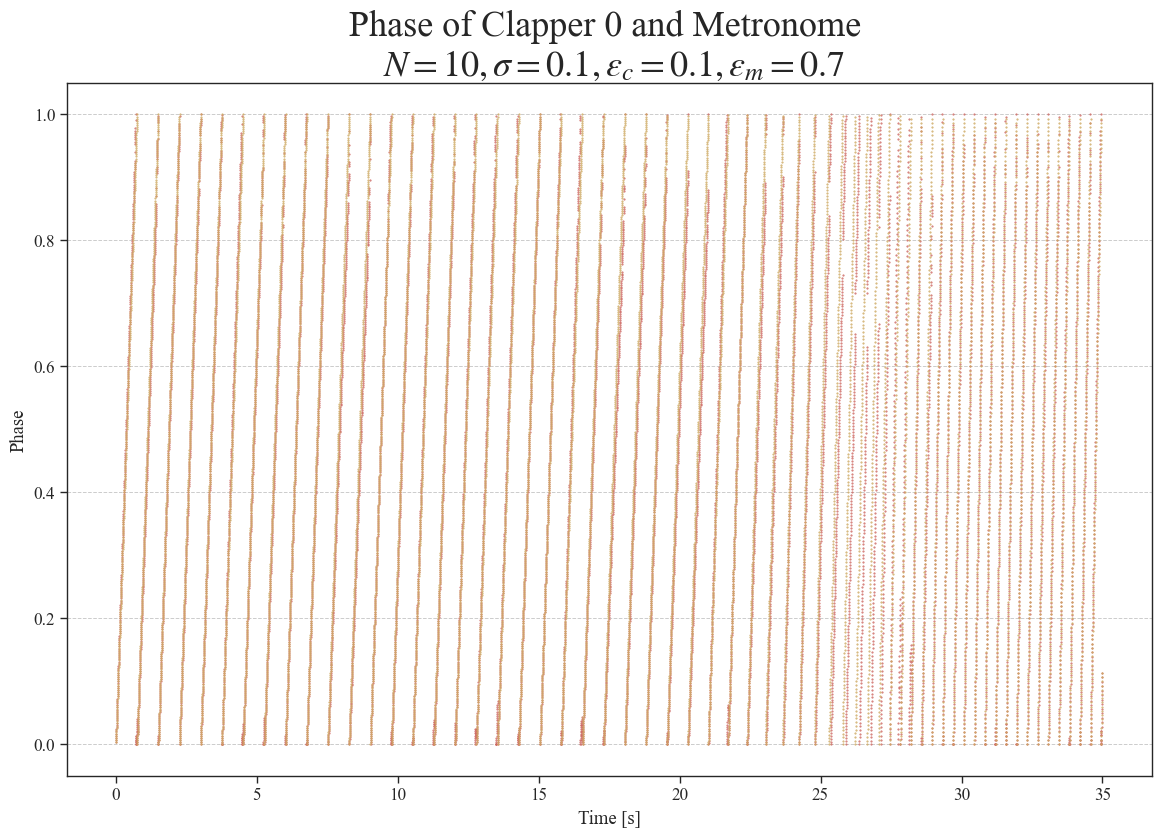

In [246]:
fig_x0, ax_x0 = plt.subplots(dpi=100, figsize=(14, 9))

t_linspace = np.arange(0, tmax, dt)
ax_x0.plot(t_linspace, x0_sig_save, label='Clapper 0', marker='.', ls='', markersize=1)
ax_x0.plot(t_linspace, x_met, label='Metronome', marker='.', ls='', markersize=1)
ax_x0.set(xlabel = 'Time [s]', ylabel = 'Phase')
ax_x0.set_title(f'Phase of Clapper 0 and Metronome \n $N = {N}, \sigma = {pars[0]}, \epsilon_c = {pars[1]}, \epsilon_m = {pars[2]} $', fontsize=26)
#ax_x0.set_xlim(0,10)

#plt.savefig('figurer/præs_2/phase_high_low_strong_coupling_freq.png')


### We plot the clapping times of the clappers and the metronome as a function of time as well as the average frequency of the clappers and the frequency of the metronome as a function of time. 

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Niels\AppData\Local\Temp\ipykernel_3724\1913071239.py:28: SyntaxWarning: invalid escape sequence '\s'
  fig.suptitle(f'Simulation of Clappers with Metronome \n $N = {N}, \sigma = {pars[0]}, \epsilon_c = {pars[1]}, \epsilon_m = {pars[2]} $', fontsize=26)
C:\Users\Niels\AppData\Local\Temp\ipykernel_3724\1913071239.py:28: SyntaxWarning: invalid escape sequence '\e'
  fig.suptitle(f'Simulation of Clappers with Metronome \n $N = {N}, \sigma = {pars[0]}, \epsilon_c = {pars[1]}, \epsilon_m = {pars[2]} $', fontsize=26)
C:\Users\Niels\AppData\Local\Temp\ipykernel_3724\1913071239.py:28: SyntaxWarning: invalid escape sequence '\e'
  fig.suptitle(f'Simulation of Clappers with Metronome \n

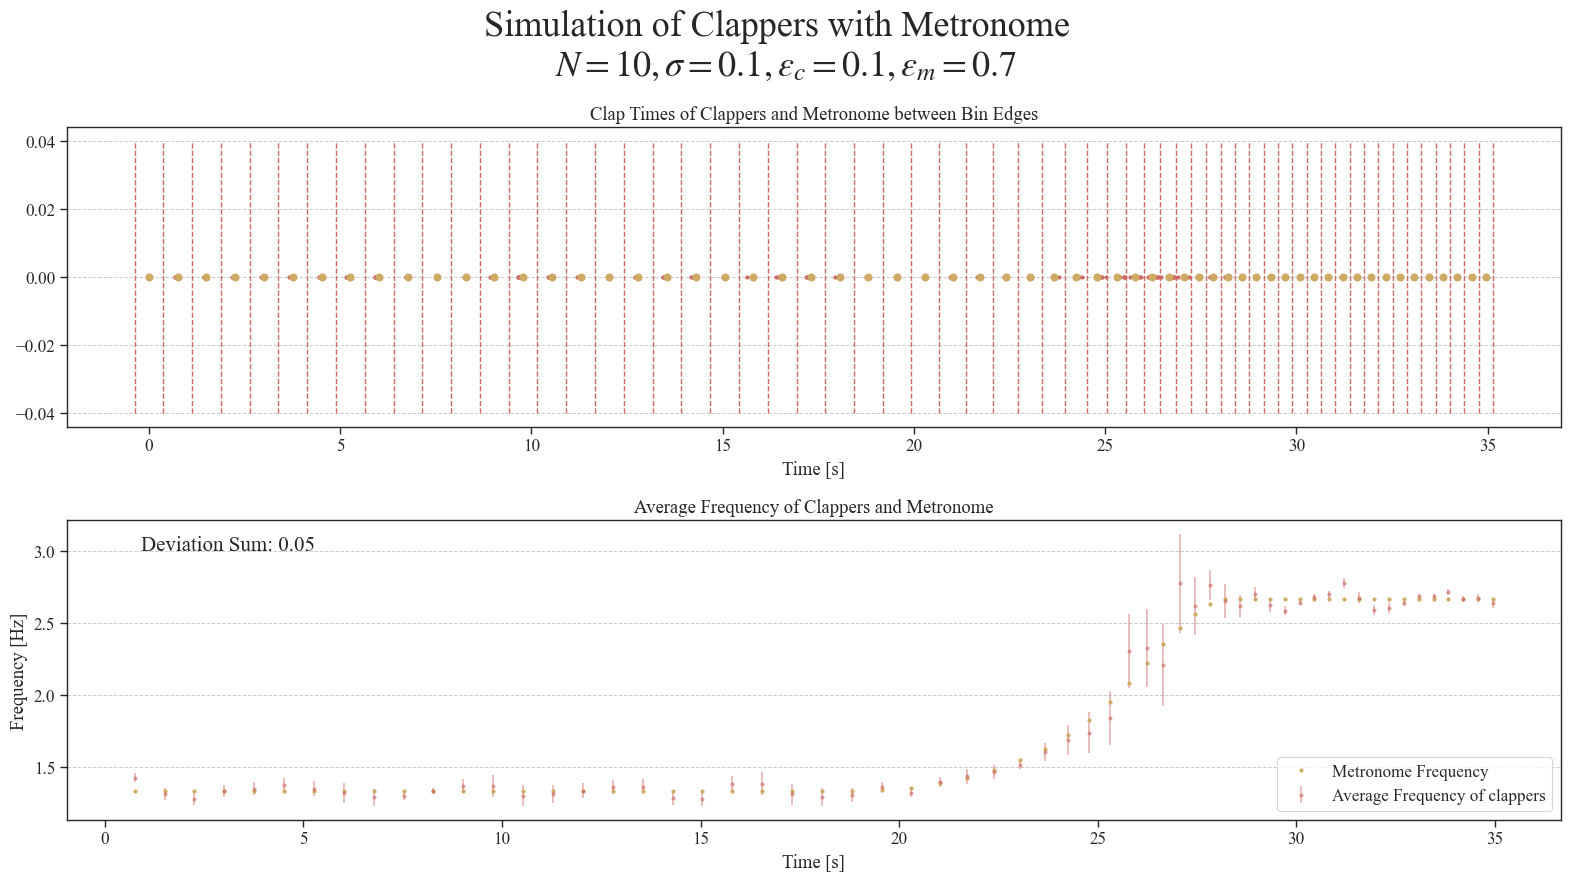

In [247]:
t_clap_comb = np.concatenate(t_sig_save)
t_clap_comb = np.concatenate((t_clap_comb, met_clap))
#print(len(t_sig_save))
avg_freq, freq_err, avg_per, fail, bin_edges, clappers_in_bin, avg_val = avg_calc(t_clap_comb, met_clap)
#print(len(met_clap), len(avg_freq))

fig, ax = plt.subplots(2,1, dpi=100)
ax[0].plot(t_clap_comb, np.zeros(len(t_clap_comb)), 'o', label='Clap Times', markersize = 2)

#for index, n_clap in enumerate(clappers_in_bin):
#    ax[0].text(met_clap[index] - 0.1, 0.021, str(n_clap), fontsize=12, clip_on=True)

ax[0].vlines(bin_edges, -0.04, 0.04, label='Bin Edges', linewidth=1, ls='--')
ax[0].plot(met_clap, np.zeros(len(met_clap)), 'o', label='Metronome Clap Times')
#ax[0].set_xlim(30.8,33.2)
ax[0].set(xlabel = 'Time [s]', title = 'Clap Times of Clappers and Metronome between Bin Edges')

met_freq = 1 / np.diff(met_clap)
deviation = np.abs(avg_freq - met_freq)
dev_mean = np.mean(deviation)

ax[1].errorbar(met_clap[1:], avg_freq, yerr=freq_err, fmt='o', label='Average Frequency of clappers', alpha=0.5, markersize = 2)
ax[1].plot(met_clap[1:], met_freq, 'o', label='Metronome Frequency', markersize = 2)
ax[1].text(0.05, 0.9, 'Deviation Sum: {:.2f}'.format(dev_mean), transform=ax[1].transAxes, fontsize=15)
ax[1].legend()
ax[1].set(xlabel = 'Time [s]', ylabel = 'Frequency [Hz]', title = 'Average Frequency of Clappers and Metronome')

fig.suptitle(f'Simulation of Clappers with Metronome \n $N = {N}, \sigma = {pars[0]}, \epsilon_c = {pars[1]}, \epsilon_m = {pars[2]} $', fontsize=26)

plt.tight_layout()
#plt.savefig('figurer/præs_2/sim_high_low_strong_coupling_freq.png')


### We plot the individual clapping times for the first 3 clappers. 

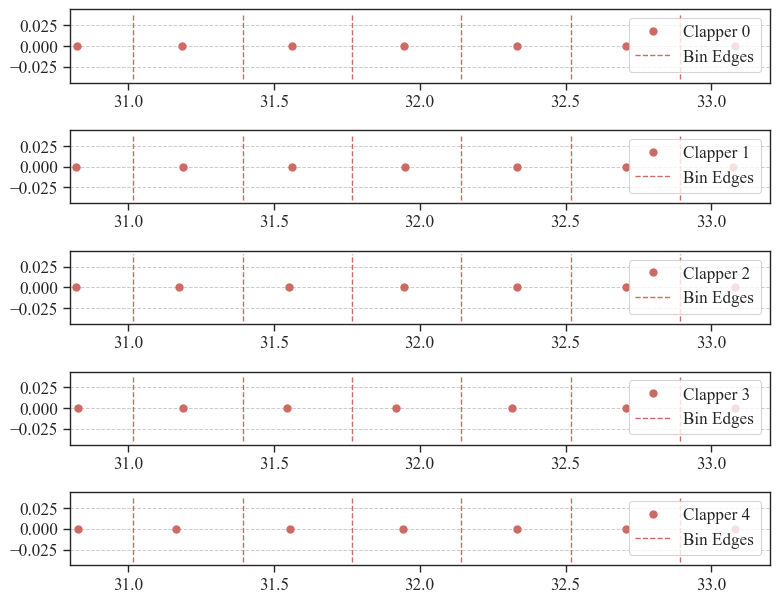

In [248]:
fig, ax = plt.subplots(len(t_sig_save), 1, dpi=100, figsize=(8, 12))
for i, clap_list in enumerate(t_sig_save):
    if i in range(5):
        ax[i].plot(clap_list, np.zeros(len(clap_list)), 'o', label=f'Clapper {i}', markersize = 5)
        #ax[i].plot(met_clap, np.zeros(len(met_clap)), 'o', label='Metronome Clap Times', markersize = 2)
        ax[i].set(xlim=(30.8, 33.2))
        ax[i].vlines(bin_edges, -0.04, 0.04, label='Bin Edges', linewidth=1, ls='--')
        ax[i].legend()
    else:
        ax[i].set_visible(False)

#fig.suptitle(f'Clap times of clappers (1-5) binned from $t = 30.8$ to $t = 33.2$, \n $N = {N}, \sigma = {pars[0]}, \epsilon_c = {pars[1]}, \epsilon_m = {pars[2]} $', fontsize=20)
fig.tight_layout()

#plt.savefig('figurer/præs_2/clap_times_high_low_strong_coupling_freq.png')

### Plotting the phase devation between the average clap time in each bin and the metronome. This is used to compare directly to our experiment data

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Niels\AppData\Local\Temp\ipykernel_3724\2668100022.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f'Phase deviation between average clap time in a bin and metronome \n $N = {N}, \sigma = {pars[0]}, \epsilon_c = {pars[1]}, \epsilon_m = {pars[2]} $', fontsize=26);
C:\Users\Niels\AppData\Local\Temp\ipykernel_3724\2668100022.py:9: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f'Phase deviation between average clap time in a bin and metronome \n $N = {N}, \sigma = {pars[0]}, \epsilon_c = {pars[1]}, \epsilon_m = {pars[2]} $', fontsize=26);
C:\Users\Niels\AppData\Local\Temp\ipykernel_3724\2668100022.py:9: SyntaxWarning: invalid escape sequence '\e'
  ax.set_t

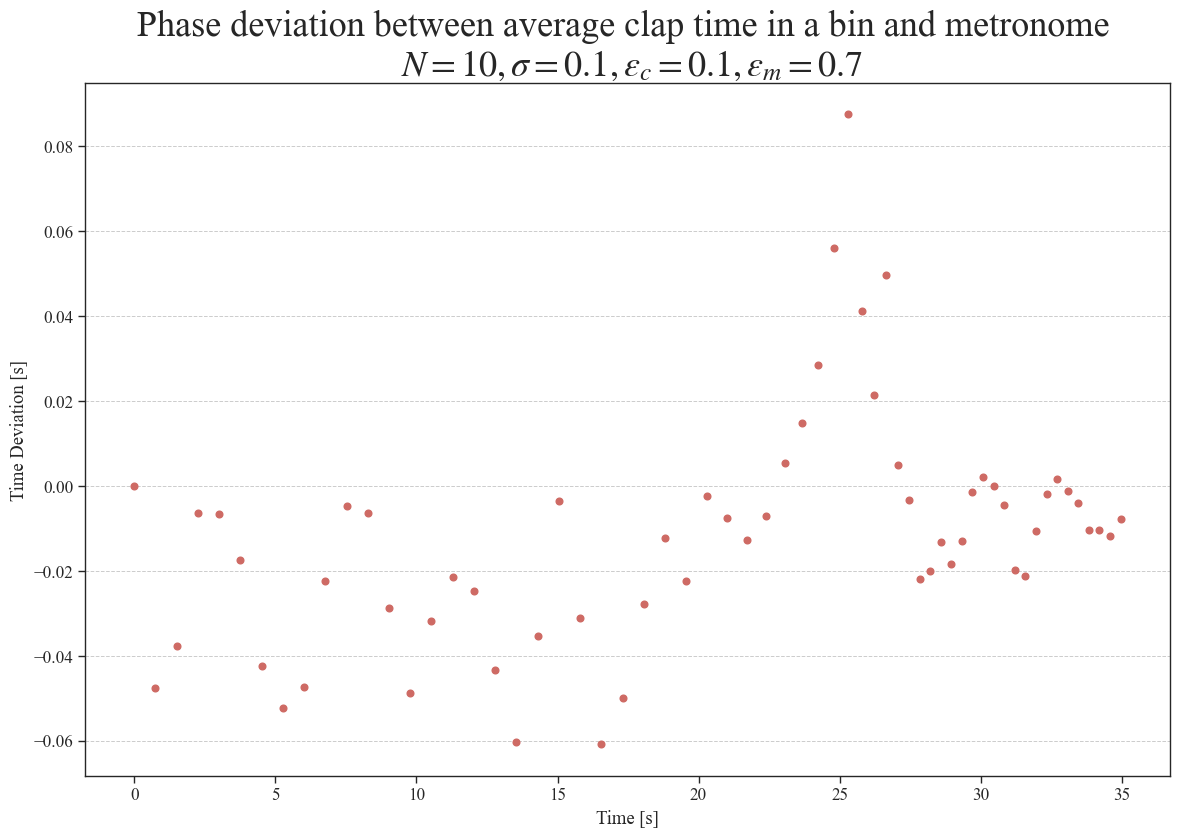

In [267]:
time_devi = []
for i, element in enumerate(met_clap):
    time_devi.append(avg_val[i] - element)

fig, ax = plt.subplots(dpi=100, figsize=(14, 9))
ax.plot(met_clap, time_devi, 'o', label='Time Deviation')
ax.set(xlabel = 'Time [s]', ylabel = 'Time Deviation [s]')

ax.set_title(f'Phase deviation between average clap time in a bin and metronome \n $N = {N}, \sigma = {pars[0]}, \epsilon_c = {pars[1]}, \epsilon_m = {pars[2]} $', fontsize=26);
plt.savefig('figurer/præs_2/phase_deviation_low_high_freq.png')

### We will get back to the following piece of code.

In [250]:
def parameter_search(N=100, sig=0.1, eps=0.1, met_eps=10, start_bpm=60, end_bpm=120):
    
    t_clap_list = []
    met_clap_list = []

    for i in tqdm(sig, desc='sigma iteration', unit='iteration'):
        sig_save = []
        sig_save_met = []
        for j in eps:
            eps_save = []
            eps_save_met =[]
            for k in met_eps:
                met_eps_save = []
                met_eps_save_met = []

                for l in N:

                    # Defining usual parameters
                    w_init = np.random.normal( start_bpm / 60 , 0.1, l )
                    x_init = np.zeros(l)
                    t_clap_init = np.zeros(l)
                    dt = 0.0025
                    tmax = 40
                    threshold_l = 24
                    threshold_h = 40


                    w_save, t_save, x0_save, avg_save, w_met_save, met_clap = sim_metronome(x_init, 
                                                                                      w_init, 
                                                                                      t_clap_init, 
                                                                                      dt, 
                                                                                      tmax, 
                                                                                      threshold_l, 
                                                                                      threshold_h, 
                                                                                      start_bpm, 
                                                                                      end_bpm, 
                                                                                      sig=i, 
                                                                                      eps=j, 
                                                                                      met_eps=k,
                                                                                      N=l)
                    t_clap_comb = np.concatenate(t_save)
                    avg_freq, freq_err, avg_per, fail = avg_calc(t_clap_comb, met_clap)
                    
                    #print(len(avg_freq), len(met_clap), '\nFails:', fail)



                    deviation = abs(avg_freq - met_clap[:1])
                    dev_mean = np.mean(deviation)


                    met_eps_save.append(avg_freq)
                    met_eps_save_met.append(met_clap)

                eps_save.append(met_eps_save)
                eps_save_met.append(met_eps_save_met)

            sig_save.append(eps_save)
            sig_save_met.append(eps_save_met)

        t_clap_list.append(sig_save)
        met_clap_list.append(sig_save_met)

    return t_clap_list, met_clap_list

        

#N = np.arange(30, 100, 10)
#sig=[0.05, 0.1, 0.15]
#eps=[0.05, 0.1, 0.15]
#met_eps=[5, 10, 15]
#
#
#t_clap_list, met_clap_list = parameter_search(N=N, sig=sig, eps=eps, met_eps=met_eps, start_bpm=60, end_bpm=120)
#



In [251]:

for i, element in enumerate(met_clap):
    if (t_sig_save[0][i] - element) > 0:
        print(i)

4
11
12
24
25
27
28
31
32
33
34
35
36
37
38
39
40
44
47
48
53
54
55
